In [1]:
using PyCall
np = pyimport("numpy")

PyObject <module 'numpy' from '/home/zequnl/.local/lib/python3.8/site-packages/numpy/__init__.py'>

In [2]:
freq = 143.0
int_freq = Int(freq)

143

In [3]:
using HDF5

flux_143 = h5read("/tigress/zequnl/radio/lagache_sed_massage/catalog_$(143.0).h5", "flux");

flux = h5read("/tigress/zequnl/radio/lagache_sed_massage/catalog_$(freq).h5", "flux")
θ = h5read("/tigress/zequnl/radio/lagache_sed_massage/catalog_$(freq).h5", "theta")
ϕ = h5read("/tigress/zequnl/radio/lagache_sed_massage/catalog_$(freq).h5", "phi");

In [4]:
using XGPaint
using Healpix
hp = pyimport("healpy")

using PyPlot
using Unitful, UnitfulAstro
import PhysicalConstants.CODATA2018: BoltzmannConstant, PlanckConstant, SpeedOfLightInVacuum

# CHANGE FOR DIFFERENT FREQUENCY ==========================
# print(KCMB_to_Jy_factor(freq * 1u"GHz"))

const TCMB = 2.725u"K"
xf(ν) = float(PlanckConstant) * ν / float(BoltzmannConstant) / TCMB
MJy_mul(ν) = 1.05e3 * expm1(xf(ν))^2 * exp(-xf(ν)) * (ν/100u"GHz")^(-4)
tSZ_mul(ν) = 1e6u"1/K" * TCMB * (xf(ν) * (exp(xf(ν))+1) / expm1(xf(ν)) - 4)

tSZ_mul (generic function with 1 method)

In [5]:
PyPlot.svg(true)

true

In [6]:
MJy_mul(freq * 1u"GHz"), tSZ_mul(freq * 1u"GHz")

(2634.1729406697013, -2.8341160526987785e6)

# Generate Radio Map

In [7]:
nside = 4096
m_radio = HealpixMap{Float64,RingOrder}(nside)
# flux_cut = 7e-3
# cut_array = flux_143 .< flux_cut  # in Jy
# XGPaint.catalog2map!(m_radio, flux[cut_array], θ[cut_array], ϕ[cut_array])
XGPaint.catalog2map!(m_radio, flux, θ, ϕ)

MJy_factor = MJy_mul(freq * 1u"GHz")
m_radio .*= MJy_factor / 1e6;  # CONVERT TO muK, note that our maps are in Jy/sr

In [8]:
using FITSIO

m_cib = readMapFromFITS("/tigress/zequnl/websky/cib_nu0$(int_freq).fits", 1, Float64);
m_cib.pixels .*= MJy_factor

tSZ_factor = tSZ_mul(freq * 1u"GHz")
m_tsz = readMapFromFITS("/tigress/zequnl/websky/tsz_8192.fits", 1, Float64);
m_tsz .*= tSZ_factor;

In [9]:
using JLD2
@load "/tigress/zequnl/radio/radio_apodized_15arcmin_7mJy_cut_at_143Ghz_mask.jld2" apo
radio_apo = apo
@load "/tigress/zequnl/radio/cib_radio_apodized_15arcmin_7mJy_cut_at_143Ghz_mask.jld2" apo


# @load "/tigress/zequnl/radio/shuffled_radio_apodized_15arcmin_7mJy_cut_at_143Ghz_mask.jld2" apo

1-element Vector{Symbol}:
 :apo

In [10]:
sum(radio_apo .< 1.0) / sum(apo .< 1.0)

0.9989656844788973

In [11]:
m_tsz = udgrade(m_tsz, nside);

In [12]:
# compute binning matrix
using PowerSpectra
P = binning_matrix(0:50:2nside, 50:50:2nside+50, ℓ -> ℓ^2, lmax=PowerSpectra.getlmax(m_tsz));
lb = P * collect(0:3nside-1)
pixelwindow = pixwin(nside)[1:nside2lmax(nside)+1];

In [13]:
maskalm = map2alm(apo)
@time 𝐌 = mcm(:TT, maskalm, maskalm);
# @load joinpath(ENV["SCRATCH"], "maskA_mcm.jld2") 𝐌

222.884311 seconds (3.64 M allocations: 1.326 GiB, 0.14% gc time, 0.47% compilation time)


In [14]:
# @save joinpath(ENV["SCRATCH"], "cib_radio_maskA_mcm.jld2") 𝐌

In [15]:
sz_alm = map2alm(m_tsz);

In [16]:
masked_sz_alm = map2alm(apo * m_tsz);

In [17]:
cl_sz = alm2cl(sz_alm)
pcl_masked_sz = alm2cl(masked_sz_alm)
cl_masked_sz = parent(𝐌 \ SpectralVector(pcl_masked_sz));

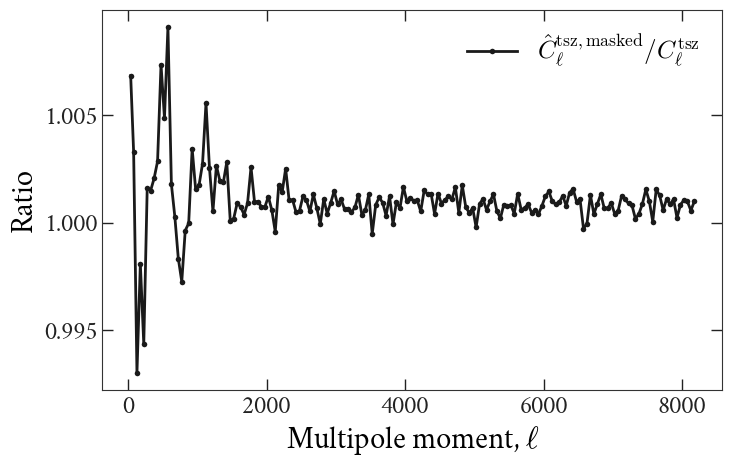

PyObject <matplotlib.legend.Legend object at 0x14b0e5bad370>

In [19]:
plt.figure(facecolor="white")
plt.plot( lb,  (P*cl_masked_sz) ./ (P*cl_sz), 
    label=raw"$\hat{C}_{\ell}^{\mathrm{tsz},\mathrm{masked}} / C_{\ell}^{\mathrm{tsz}}$")
plt.ylabel(raw"Ratio")
plt.xlabel(raw"Multipole moment, $\ell$")
plt.legend()
# plt.ylim(0.95, 1.2)

In [8]:
ENV["SCRATCH"] = "/tigress/zequnl/xgpaint/"
@time halo_pos, halo_mass = read_halo_catalog_hdf5(
    joinpath(ENV["SCRATCH"],"websky_halos-light.hdf5"));

 26.343016 seconds (379.43 k allocations: 25.735 GiB, 1.42% gc time, 1.97% compilation time)


In [9]:
fwhm_100 = 2.2
beamed_radio = hp.sphtfunc.smoothing(m_radio.pixels, fwhm=fwhm_100);
beamed_cib = hp.sphtfunc.smoothing(m_cib.pixels, fwhm=fwhm_100);
beamed_tsz = hp.sphtfunc.smoothing(m_tsz.pixels, fwhm=fwhm_100);

In [10]:
mass_cut_array = halo_mass .> 10^14.5
positions = halo_pos[:, mass_cut_array];

In [11]:
norm(x) = sqrt(x[1]^2 + x[2]^2 + x[3]^2)
unitize(x) = x ./ norm(x)

unitize (generic function with 1 method)

In [12]:
max_disc_in_arcmin = 6
max_disc = deg2rad(max_disc_in_arcmin / 60)

0.0017453292519943296

In [13]:
using ProgressMeter

function get_discs(beamed_map::Array{T}, res, pos) where T
#     res = beamed_map.resolution
    radii = T[]
    disc_fluxes = T[]
    
    num_halos = size(pos, 2)
    @showprogress for i in 1:num_halos
        pixel_inds = hp.query_disc(nside, unitize(positions[:,i]), max_disc) .+ 1
        append!(disc_fluxes, beamed_map[pixel_inds])
        vec1 = unitize(positions[:,i]) #pix2vecRing(res, vec2pixRing(res, positions[:,i]...))
        vec2 = hp.pixelfunc.pix2vec(res.nside, pixel_inds .- 1) #[pix2angRing(res, pixind) for pixind in pixel_inds]
#         angdists = [hp.rotator.angdist(vec1, [vec2[1][i_discpix], vec2[2][i_discpix]])[1] for i_discpix in 1:length(pixel_inds) ]
        angdists = hp.rotator.angdist(vec1, vec2)
        append!(radii, angdists)
    end
    
    return radii, disc_fluxes
end

get_discs (generic function with 1 method)

In [14]:
using Interpolations
spline(x, y) = scale(interpolate(y, BSpline(Cubic(Line(OnGrid())))), x)
# spline_∂ₓ(f, x_grid) = spline(x_grid, [Interpolations.gradient(f, x)[1] for x in x_grid])


spline (generic function with 1 method)

In [15]:
# function get_profile(m, res)
#     r, f = get_discs(m, res, positions)
#     Δr = max_disc/30
#     radial_coord = Δr/100:Δr:max_disc
#     cumulative_fluxes = [sum(f[r .< r₀]) for r₀ in radial_coord];
#     profile = spline_∂ₓ(spline(radial_coord, cumulative_fluxes), radial_coord)
#     return profile
# end

In [16]:
function get_profile(m, res)
    r, f = get_discs(m, res, positions)
    Δr = max_disc/30
    radial_coord = 0.0:Δr:max_disc
    cumulative_fluxes = [
        sum( f[((r₀-Δr) .< r) .& (r .< (r₀+Δr))] ) / (π * ((r₀+Δr)^2 - max(0.0, r₀-Δr)^2))
        for r₀ in radial_coord];
    cumulative_fluxes[1] = sum( f[r .< Δr] ) / (π * Δr^2) 
    
    profile = spline(radial_coord, cumulative_fluxes) #spline_∂ₓ(
        
#         , radial_coord)
    return profile
end

get_profile (generic function with 1 method)

In [17]:
mask = hp.read_map("/tigress/zequnl/websky/radiomask_143_7mJy.fits");

In [18]:
profile_radio = get_profile(beamed_radio, m_radio.resolution)
profile_tsz = get_profile(beamed_tsz, m_radio.resolution)
profile_cib = get_profile(beamed_cib, m_radio.resolution);

# profile_radio = get_profile(m_radio.pixels .* mask, m_radio.resolution)
# profile_tsz = get_profile(m_tsz.pixels .* mask, m_radio.resolution)
# profile_cib = get_profile(m_cib.pixels .* mask, m_radio.resolution);

Progress: 100%|█████████████████████████████████████████| Time: 0:00:11
Progress: 100%|█████████████████████████████████████████| Time: 0:00:11
Progress: 100%|█████████████████████████████████████████| Time: 0:00:11


In [19]:
# r, fr = get_discs(m_radio.pixels, m_radio.resolution, positions)
# r, fsz = get_discs(beamed_tsz, m_radio.resolution, positions)

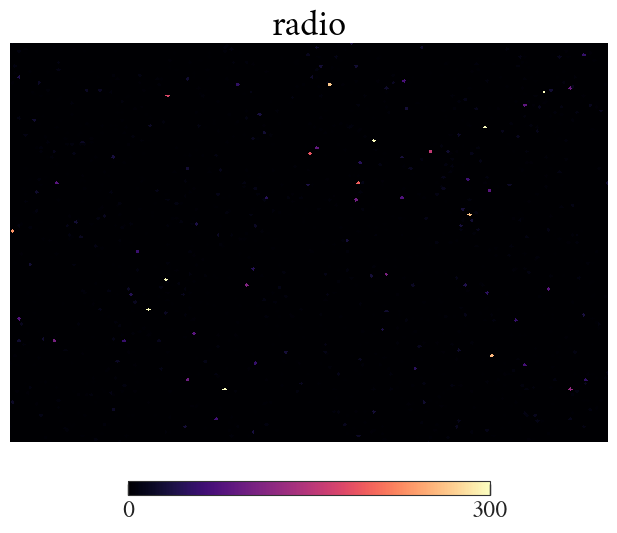

In [20]:
hp.cartview((m_radio.pixels), lonra=[-1,2], latra=[-1,1], max=3e2, title="radio")

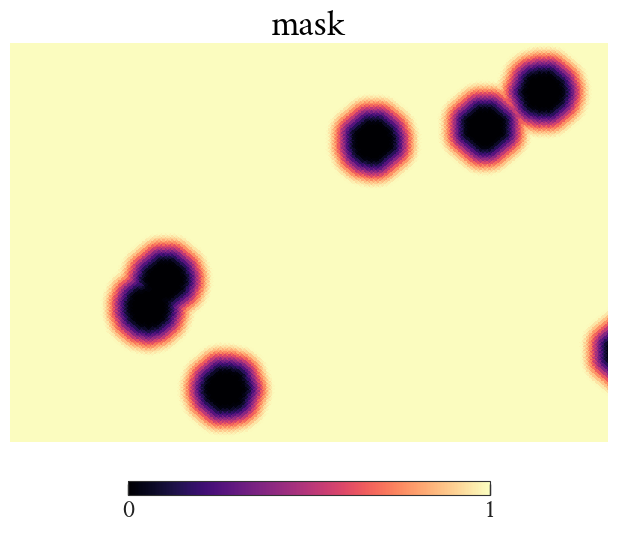

In [21]:
hp.cartview(mask, lonra=[-1,2], latra=[-1,1], title="mask")

In [22]:
sum(m_radio.pixels .* mask), sum(m_radio.pixels)

(7.382080646836439e7, 1.4086878676059645e8)

In [23]:
profile_radio = get_profile(m_radio.pixels .* mask, m_radio.resolution)
profile_tsz = get_profile(m_tsz.pixels .* mask, m_radio.resolution)
profile_cib = get_profile(m_cib.pixels .* mask, m_radio.resolution);

Progress: 100%|█████████████████████████████████████████| Time: 0:00:11
Progress: 100%|█████████████████████████████████████████| Time: 0:00:11
Progress: 100%|█████████████████████████████████████████| Time: 0:00:12


In [27]:
profile_norm = 3.6353e12

3.6353e12

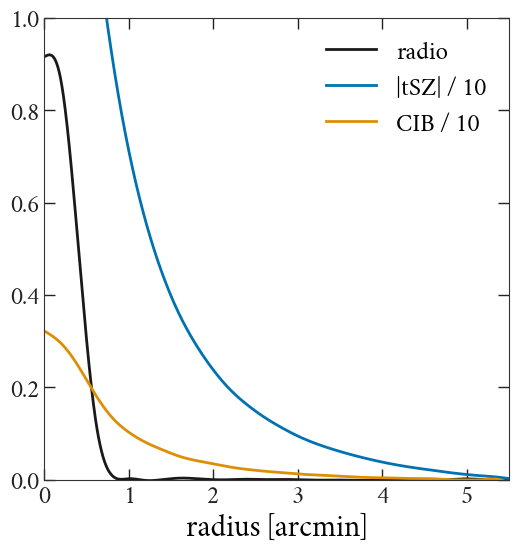

'Cochineal-Roman.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


In [28]:
figure(figsize=(6,6))

Δr = max_disc/30
plotting_r = Δr/10:max_disc/1000:(max_disc-Δr)
r_arcmin = rad2deg.(plotting_r) .* 60

monopole = (profile_radio.(plotting_r))[length(plotting_r)]
plot(r_arcmin, (profile_radio.(plotting_r)  .- monopole) ./ profile_norm, "-", label="radio")

monopole = (profile_tsz.(plotting_r))[length(plotting_r)]
plot(r_arcmin, abs.(profile_tsz.(plotting_r) .- monopole) ./ 10    ./ profile_norm , "-", label="|tSZ| / 10")

monopole = (profile_cib.(plotting_r))[length(plotting_r)]
plot(r_arcmin, (profile_cib.(plotting_r) .- monopole) ./ 10   ./ profile_norm, "-", label="CIB / 10")

# plot(radial_coord, predict(approx, radial_coord), "-")
legend()
xlabel("radius [arcmin]")
# yscale("log")
# title("unbeamed $(freq) GHz (masked)")
xlim(0, 5.5)
ylim(0.0, 1)
savefig("figures/beamed_143_masked.pdf")

In [46]:
profile_radio = get_profile(m_radio.pixels, m_radio.resolution)
profile_tsz = get_profile(m_tsz.pixels, m_radio.resolution)
profile_cib = get_profile(m_cib.pixels, m_radio.resolution);

Δr = max_disc/30
plotting_r = Δr/10:max_disc/1000:(max_disc-Δr)
r_arcmin = rad2deg.(plotting_r) .* 60;

Progress: 100%|█████████████████████████████████████████| Time: 0:00:10
Progress: 100%|█████████████████████████████████████████| Time: 0:00:10
Progress: 100%|█████████████████████████████████████████| Time: 0:00:10


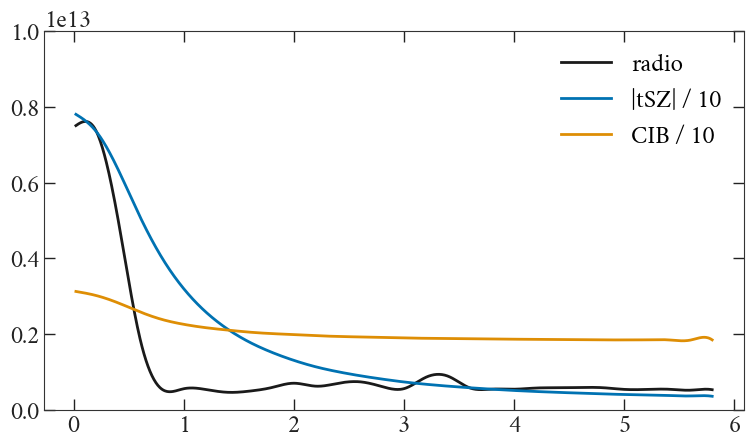

'Cochineal-Roman.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


In [47]:
plot(r_arcmin, profile_radio.(plotting_r), "-", label="radio")
plot(r_arcmin, abs.(profile_tsz.(plotting_r)) ./ 10  , "-", label="|tSZ| / 10")
plot(r_arcmin, profile_cib.(plotting_r) ./ 10, "-", label="CIB / 10")
# plot(radial_coord, predict(approx, radial_coord), "-")
legend()
# yscale("log")
# title("unbeamed $(freq) GHz (unmasked, no flux cut)")
ylim(0.0, 1e13)
tight_layout()
savefig("figures/beamed_143_unmasked_no_cut.pdf")

In [48]:
# r_arcmin = rad2deg.(plotting_r) .* 60
# plot(r_arcmin, profile_radio.(plotting_r) ./ ( π .* ((plotting_r .+ Δr/50).^2 - (plotting_r .- Δr/50).^2)), "-", label="radio")
# plot(r_arcmin, abs.(profile_tsz.(plotting_r)) ./ ( π .* ((plotting_r .+ Δr/50).^2 - (plotting_r .- Δr/50).^2)), "-", label="|tSZ|")
# plot(r_arcmin, profile_cib.(plotting_r) ./ ( π .* ((plotting_r .+ Δr/50).^2 - (plotting_r .- Δr/50).^2)), "-", label="CIB")
# # plot(radial_coord, predict(approx, radial_coord), "-")
# legend()
# yscale("log")
# title(freq)
# # ylim(0.0, 0.5e20)

In [ ]:
rad2deg(sqrt(nside2pixarea(nside))) * 60

In [ ]:
360 * 60 / 3nside